# Credit Card Fraud Detection
We will explore a highly imbalanced credit card transaction dataset on European cardholders from September 2013.  It has been anonymized, processed (mostly) and has undergone PCA transformation.  

## Setup and Exploratory Data Analysis

In [356]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

import kagglehub

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, fbeta_score, roc_auc_score, roc_curve, make_scorer
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier, plot_importance

from imblearn.over_sampling import SMOTE

from time import perf_counter
import os

Let's set a random seed and use it everywhere in order to generate reproducible results.  

In [357]:
RANDOM_SEED = 0
sns.set_theme()

Let's load the data and have a look at the features

In [358]:
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

Path to dataset files: /Users/adrianbrudnicki/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


In [359]:
full_path = os.path.join(path, "creditcard.csv")
df = pd.read_csv(full_path)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [360]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [361]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [362]:
df.isna().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [363]:
df.duplicated().sum()


np.int64(1081)

All numeric, no null values, looks like it has indeed been pre-processed nicely.  We do see a few duplicate rows so we will drop those.  

In [364]:
df = df.drop_duplicates()

## Initial Data Visualization

Let's explore just how unbalanced the output class is.  

In [365]:
def compare_class_weights(df):
    pct_fraud = df.Class.value_counts()[0] / len(df) * 100
    pct_legit = 100 - pct_fraud
    ax = sns.countplot(df, x="Class")
    ax.bar_label(ax.containers[0], labels=(f"{pct_fraud:.2f}%", f"{pct_legit:.2f}%"))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x/1000:,.0f}K"))
    plt.title("Rate of Fraudulent Transactions")
    ax.set_xticks([0, 1])
    ax.set(xticklabels=["Legitimate", "Fraudulent"])
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    plt.show()

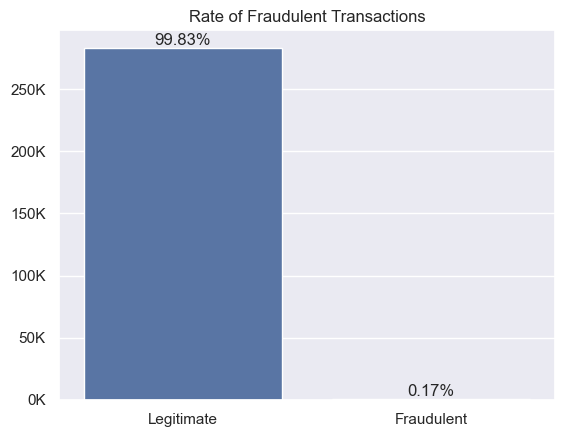

In [366]:
compare_class_weights(df)

That is pretty imbalanced, we will handle this a little later.  Now let's create an Hours feature (from the Time feature).

In [367]:
df_fraud = df[df["Class"] == 1]
df_legit = df[df["Class"] == 0]

Now let's spam some Kernel Density Estimates and see how the various features are distributed with respect to the output class.   

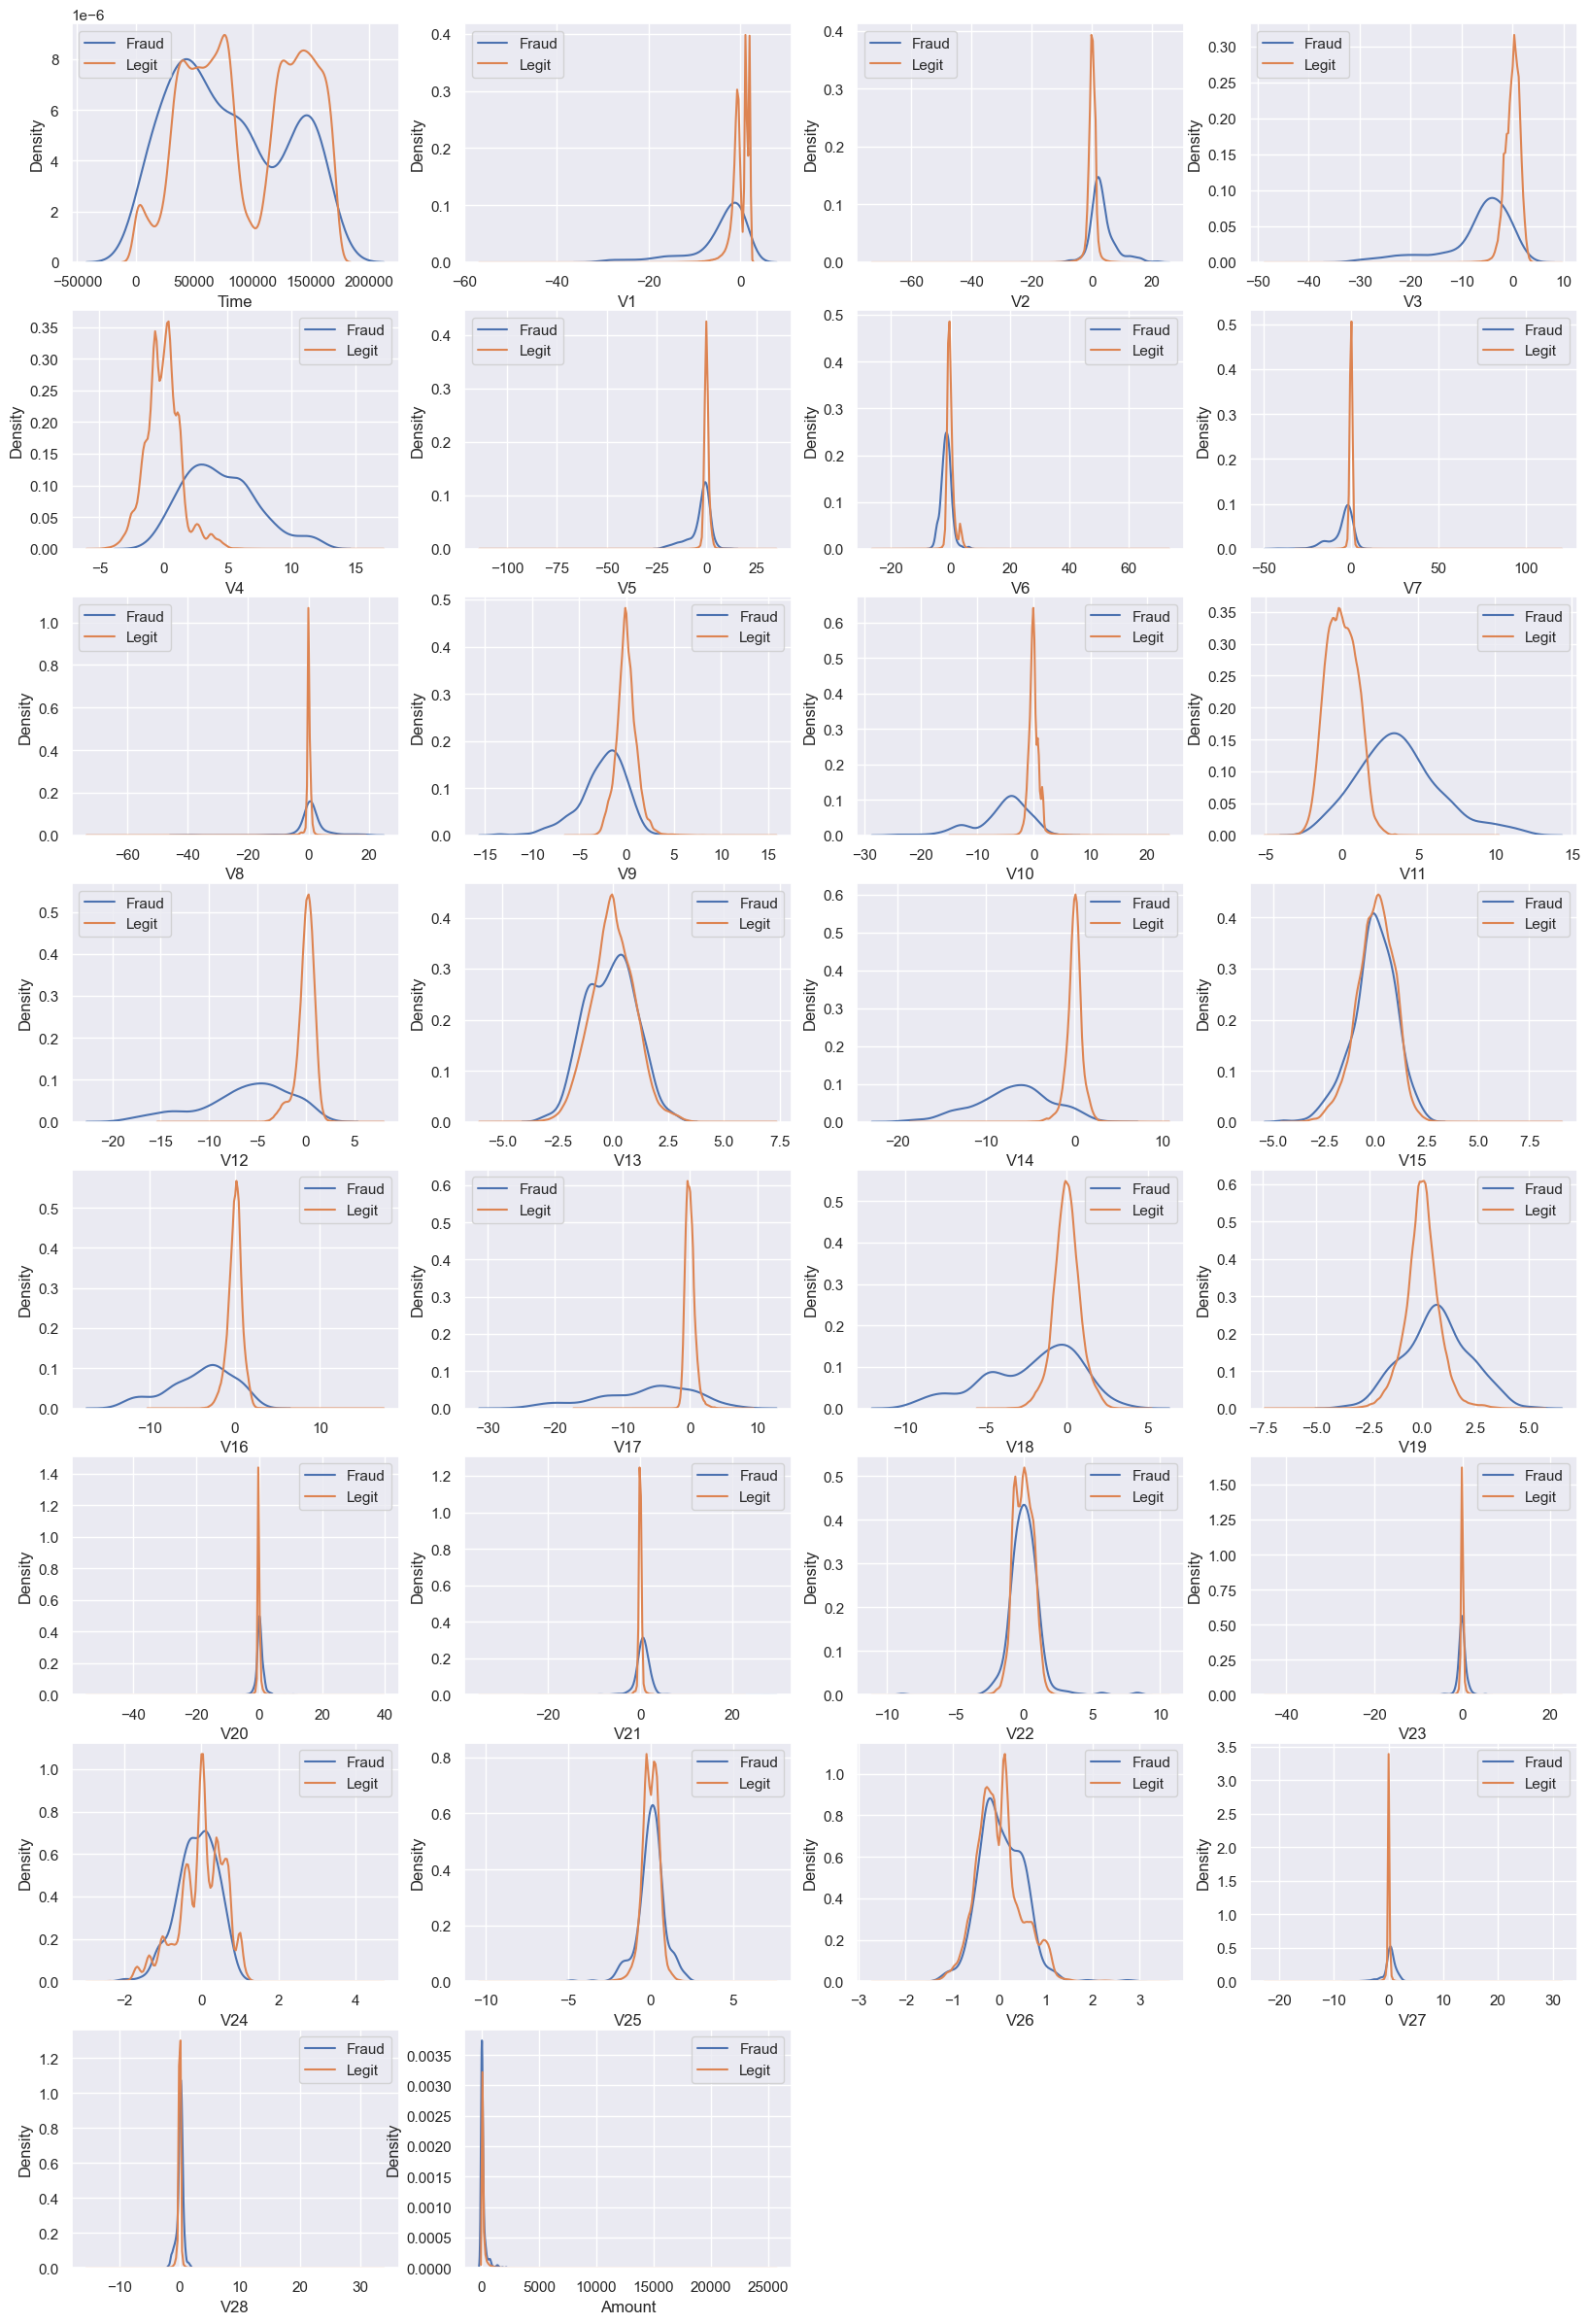

In [368]:
plt.figure(figsize=(20, 30))
for i, col in enumerate(df.drop("Class",axis=1).columns):
    plt.subplot(8, 4, i+1)
    ax1 = sns.kdeplot(data=df_fraud, x=col, label="Fraud")
    sns.kdeplot(data=df_legit, x=col, label="Legit")
    ax1.legend()
plt.show()

A lot of the V features have a different distribution for fraudulent transactions, as does time.  There might be something going on with the Amount feature but it's hard to tell from this graph.  Let's drill a little deeper into this.  

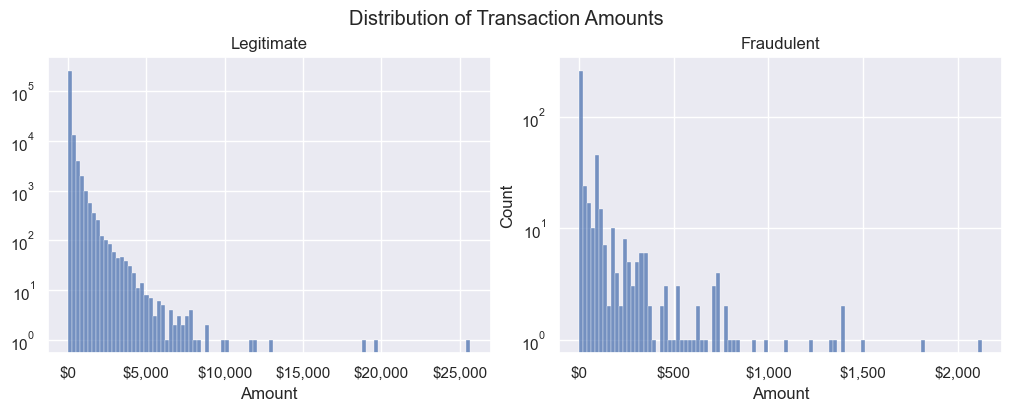

In [369]:
fig, (ax0, ax1) = plt.subplots(1, 2,  figsize=(10, 4), layout="constrained")
fig.suptitle("Distribution of Transaction Amounts")
sns.histplot(df_legit.Amount, bins=100, ax=ax0)
ax0.set_title("Legitimate")
ax0.set_yscale("log")
ax0.set_ylabel(None)
ax0.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${x:,.0f}"))
sns.histplot(df_fraud.Amount, bins=100, ax=ax1)
ax1.set_title("Fraudulent")
ax1.set_yscale("log")
ax1.xaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"${x:,.0f}"))
plt.show()

The fraudulent transactions are far more likely to be for a lower amount.  

## Data Preprocessing

To address the aforementioned class imbalance issue, we first tried undersampling, which consists of reducing the majority class records until they equal the minority class.  This has the benefit making the models run much faster, but unfortunately the predictive power of our model suffered substantially.  This makes sense, since we removed a very large number of records to balance the classes. 

Now let's try oversampling via Synthetic Minority Over-sampling Technique or SMOTE.  

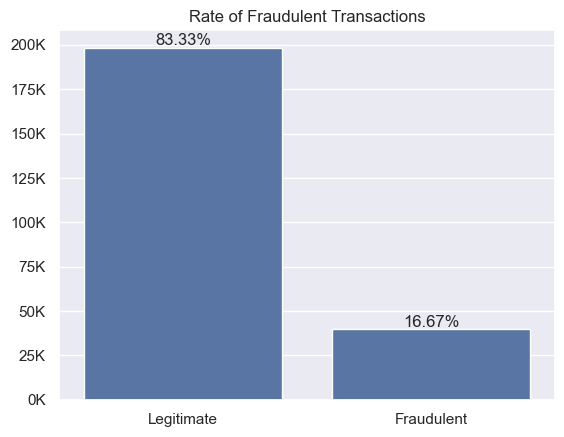

In [370]:
X = df.drop("Class", axis=1)
y = df["Class"]
smote = SMOTE(sampling_strategy=.2, random_state=RANDOM_SEED)
X_train_imbalanced, X_test, y_train_imbalanced, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)
X_train, y_train = smote.fit_resample(X_train_imbalanced, y_train_imbalanced)
compare_class_weights(pd.DataFrame(y_train, columns=["Class"]))

In [371]:
scaler = StandardScaler()
features_to_scale = ["Time", "Amount"] 
X_train[features_to_scale] =  scaler.fit_transform(X_train[features_to_scale])
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])


## Model Selection and Evaluation


Let's define some helper functions to evaluate and compare different models.

In [372]:
def evaluate_model(model, X_train, X_test, y_train, y_test, threshold=0.5):
    model.fit(X_train, y_train)
    y_pred_probas = model.predict_proba(X_test)[:, -1]
    y_pred = (y_pred_probas > threshold).astype(int)
    print(model)
    print(classification_report(y_test, y_pred, digits=3))
    print(f"f2 score = {fbeta_score(y_test, y_pred, beta=2):.3f}")
    cmatrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cmatrix, annot=True, fmt="d", cmap="magma", xticklabels=["Legitimate", "Fraud"], yticklabels=["Legitimate", "Fraud"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_pred_probas)
    auc = roc_auc_score(y_test, y_pred_probas)
    sns.lineplot(x=fpr, y=tpr, label=f"AUC: {auc:.3f}")
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.show() 

In [373]:
def compare_models(models, X_train, y_train, cv=5, scoring=make_scorer(fbeta_score, beta=2)):
    for model in models:
        print(f"Training: {model}")
        train_start = perf_counter()
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
        train_stop = perf_counter()
        print(f"Training Time: {train_stop - train_start:,.2f}s")
        print(f"Score: {scores.mean():.4f} (+/- {scores.std() * 2:.4f})")
        print("*" * 80)

We will run a few base classifiers and compare their F2 scores.  I'm using the F2 score since it's a blend of precision and recall with a double-weighting of recall so it weighs false negatives more.  Missing fraudulent transactions is very costly whereas false positives are just inconvenient.  

In [374]:
models = [RidgeClassifier(random_state=RANDOM_SEED), RandomForestClassifier(random_state=RANDOM_SEED), 
         SVC(random_state=RANDOM_SEED), KNeighborsClassifier(), XGBClassifier(random_state=RANDOM_SEED)]
compare_models(models, X_train, y_train)

Training: RidgeClassifier(random_state=0)
Training Time: 2.25s
Score: 0.7952 (+/- 0.0100)
********************************************************************************
Training: RandomForestClassifier(random_state=0)
Training Time: 101.58s
Score: 0.9981 (+/- 0.0017)
********************************************************************************
Training: SVC(random_state=0)
Training Time: 35.68s
Score: 0.9744 (+/- 0.0050)
********************************************************************************
Training: KNeighborsClassifier()


/Users/adrianbrudnicki/code/python/cc-fraud-detection/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Training Time: 24.78s
Score: 0.9987 (+/- 0.0004)
********************************************************************************
Training: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
Training Time: 2.26s
Score: 0.9996 (+/- 0.0003)
***************************************************

While these mostly fared well, the Random Forest and XGB scored best.  Since XGB is so much faster and acheives nearly the same score, we will use it.  Let's do some hyperparameter tuning.  

In [375]:
def find_best_params(model, search_spaces, X, y, n_iter=25, cv=5, scoring=make_scorer(fbeta_score, beta=2)):
    search = RandomizedSearchCV(model, search_spaces, n_iter=n_iter, cv=cv, scoring=scoring, n_jobs=-1, random_state=RANDOM_SEED)
    search.fit(X, y)
    print(f"Best score: {search.best_score_}")
    print(f"Best parameters found: {search.best_params_}")
    return search.best_estimator_

In [376]:
base_xgb = XGBClassifier(random_state=RANDOM_SEED, max_depth=4, n_estimators=1000)
xgb_search_spaces = {
    "max_depth": np.arange(3, 8),
    "learning_rate": [0.3, 0.2, 0.1, 0.05, 0.01],
    "n_estimators": np.arange(100, 1000, 50),
    "subsample": np.arange(0.5, 1, .1),
    "colsample_bytree": np.arange(0.5, 1, .1) 
}
best_xgb = find_best_params(base_xgb, xgb_search_spaces, X_train, y_train)



Best score: 0.9997478794128185
Best parameters found: {'subsample': np.float64(0.7), 'n_estimators': np.int64(950), 'max_depth': np.int64(3), 'learning_rate': 0.2, 'colsample_bytree': np.float64(0.5)}


Let's see how our models perform on the test data.  

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, ...)
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     84976
           1      0.896     0.845     0.870       142

    accuracy                          1.000     85118
   macro avg      0.948 

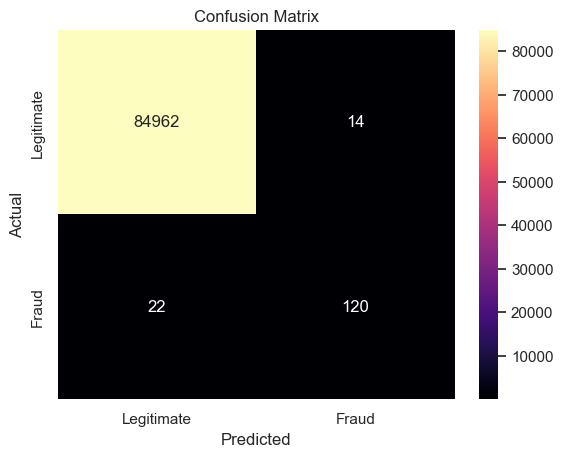

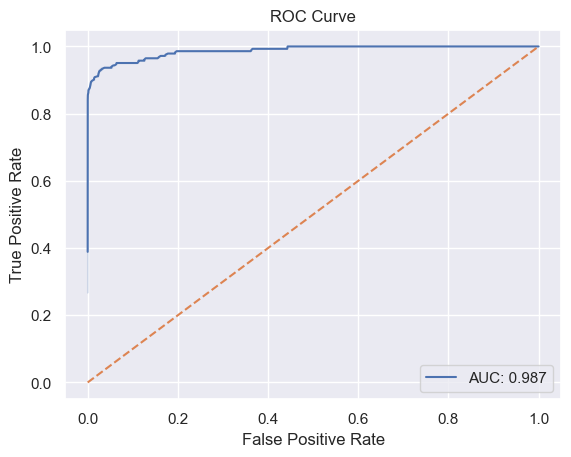

In [377]:
evaluate_model(base_xgb, X_train, X_test, y_train, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.5), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(3), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(950), n_jobs=None,
              num_parallel_tree=None, ...)
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     84976
           1      0.902     0.838     0.869       142

    accuracy                       

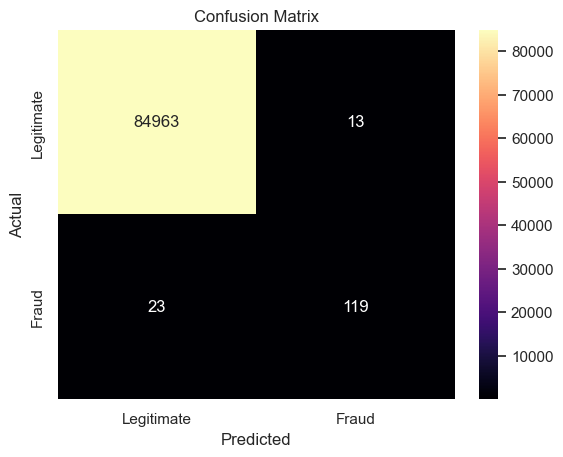

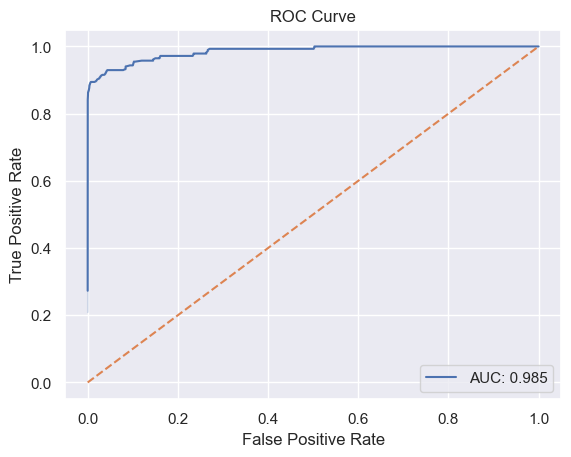

In [378]:
evaluate_model(best_xgb, X_train, X_test, y_train, y_test)

Let's try the same model but with a lower threshold to raise recall.  

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=np.float64(0.5), device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, feature_weights=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=np.int64(3), max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=np.int64(950), n_jobs=None,
              num_parallel_tree=None, ...)
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     84976
           1      0.747     0.852     0.796       142

    accuracy                       

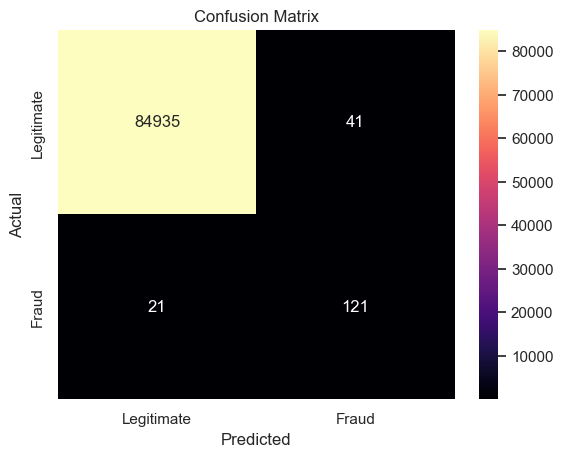

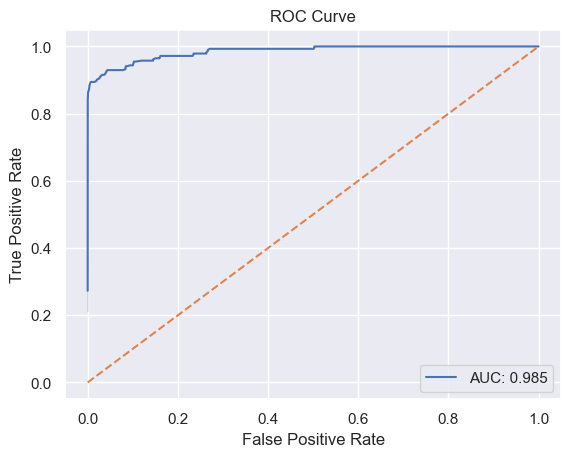

In [379]:
evaluate_model(best_xgb, X_train, X_test, y_train, y_test, threshold=0.1)

Interestingly, the base model performed slightly better wrt f2 score.  Let's see which features were considered most important by XGB.  

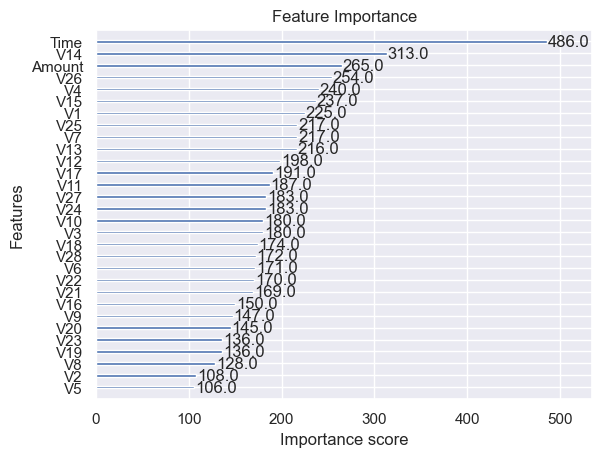

In [380]:
plot_importance(base_xgb, title="Feature Importance")
plt.show()

Now let's see how the K Nearest Neighbors alogrithm performs.

In [381]:
base_kn = KNeighborsClassifier()
kn_search_spaces = {
    "n_neighbors": np.arange(1, 10),
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}
best_kn = find_best_params(base_kn, kn_search_spaces, X_train, y_train)

Best score: 0.9995513386165072
Best parameters found: {'weights': 'uniform', 'n_neighbors': np.int64(2), 'metric': 'manhattan'}


KNeighborsClassifier()
              precision    recall  f1-score   support

           0      1.000     0.999     0.999     84976
           1      0.616     0.859     0.718       142

    accuracy                          0.999     85118
   macro avg      0.808     0.929     0.859     85118
weighted avg      0.999     0.999     0.999     85118

f2 score = 0.796


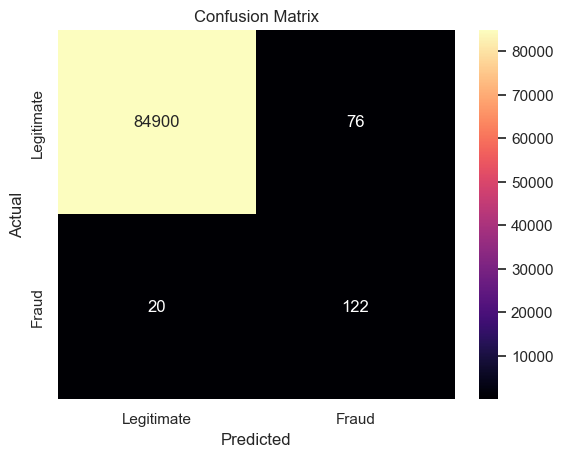

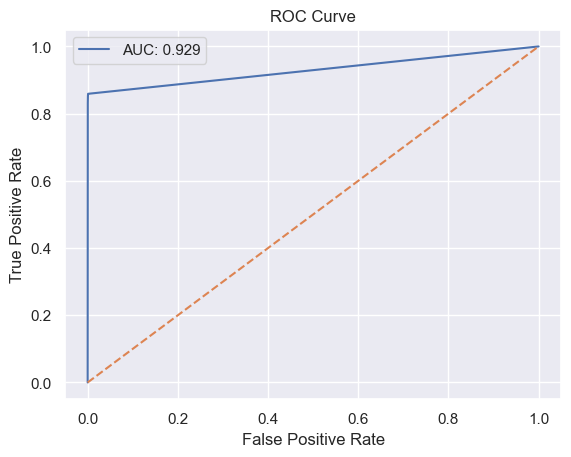

In [382]:
evaluate_model(base_kn, X_train, X_test, y_train, y_test)

KNeighborsClassifier(metric='manhattan', n_neighbors=np.int64(2))
              precision    recall  f1-score   support

           0      1.000     1.000     1.000     84976
           1      0.849     0.831     0.840       142

    accuracy                          0.999     85118
   macro avg      0.924     0.915     0.920     85118
weighted avg      0.999     0.999     0.999     85118

f2 score = 0.835


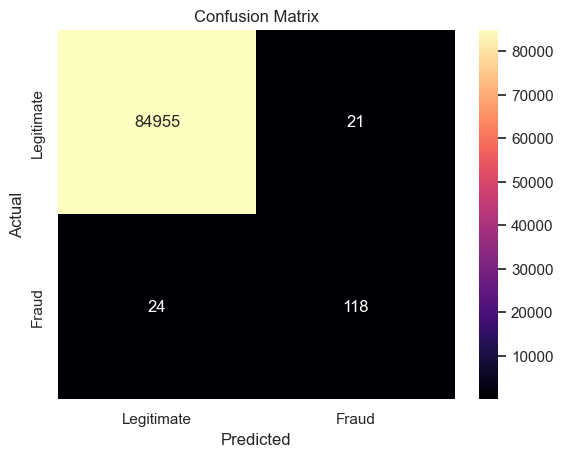

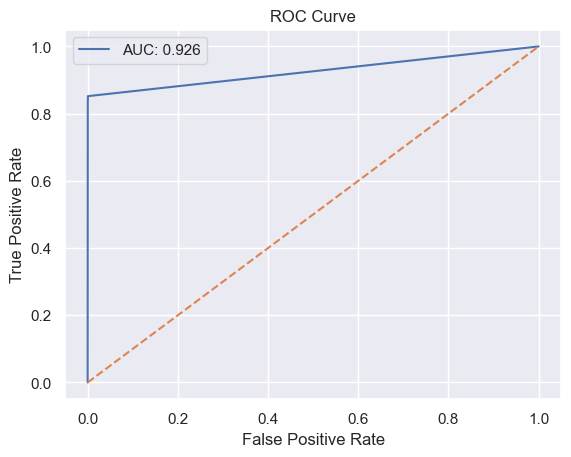

In [383]:
evaluate_model(best_kn, X_train, X_test, y_train, y_test)